In [1]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from datetime import timedelta
from datetime import datetime
import scipy.stats as stats

import requests as r
import pandas as pd
import seaborn as s
import numpy as np

import holidays
ie_holidays = holidays.Ireland()

import postgres
import gmaps
import googlemaps
import json
import math

import xgboost as xgb
from sklearn import metrics

from tqdm import tnrange, tqdm_notebook

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

import pickle

In [2]:
import importlib
importlib.reload(postgres.config)

<module 'config' from '/media/storage/College/S3/Github/DublinBus/Analytics/config.py'>

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
# data = pd.read_csv("stored_queries/combined145.csv")
# data.columns = ['dayofservice','tripid','lineid','direction','progrnumber','stopid','plannedDEP','plannedARR','actualDEP','actualARR','routeid']
# data.head(2)
# data.dtypes

In [5]:
# data.dayofservice = pd.to_datetime(data.dayofservice.loc[:])
# data.lineid = data.lineid.astype('category')
# data.routeid= data.routeid.astype('category')
# data.sort_values(by=['dayofservice','lineid','tripid','direction','progrnumber'],inplace=True)

# Trips Data

In [6]:
tripsdata = pd.read_csv("stored_queries/trips_df.csv")
tripsdata.head()

,Unnamed: 0,dayofservice,tripid,lineid,routeid,direction,planned_arr,planned_dep,actual_arr,actual_dep
0,0,2018-06-17,7013606,7A,7A_85,1,66484,62400,67065.0,62901.0
1,1,2018-07-03,7137867,41C,41C_79,2,51620,47700,NaN,47293.0
2,2,2018-02-16,6258567,31,31_15,1,74041,71400,74297.0,71449.0
3,3,2018-08-27,7499178,67,67_6,2,59030,54720,NaN,54687.0
4,4,2018-08-27,7500294,44,44_36,2,85563,81000,85557.0,81004.0


In [7]:
tripsdata = tripsdata[['dayofservice', 'tripid', 'lineid', 'routeid', 'direction', 'actual_arr', 'actual_dep']]
tripsdata.dayofservice = pd.to_datetime(tripsdata.dayofservice)
tripsdata.dropna(inplace=True)

In [8]:
tripsdata['triplength'] = tripsdata.actual_arr - tripsdata.actual_dep
tripsdata.actual_arr = tripsdata.dayofservice + pd.to_timedelta(tripsdata.actual_arr, unit='seconds')
tripsdata.actual_dep = tripsdata.dayofservice + pd.to_timedelta(tripsdata.actual_dep, unit='seconds')
tripsdata['leavehour'] = tripsdata.actual_dep.dt.hour

In [9]:
tripsdata['weather_merge_time'] = tripsdata.actual_dep.dt.round('H') #  .dt is super useful. 

In [10]:
tripsdata.head()

,dayofservice,tripid,lineid,routeid,direction,actual_arr,actual_dep,triplength,leavehour,weather_merge_time
0,2018-06-17,7013606,7A,7A_85,1,2018-06-17 18:37:45,2018-06-17 17:28:21,4164.0,17,2018-06-17 17:00:00
2,2018-02-16,6258567,31,31_15,1,2018-02-16 20:38:17,2018-02-16 19:50:49,2848.0,19,2018-02-16 20:00:00
4,2018-08-27,7500294,44,44_36,2,2018-08-27 23:45:57,2018-08-27 22:30:04,4553.0,22,2018-08-27 23:00:00
5,2018-05-23,6782602,27,27_17,2,2018-05-23 19:37:32,2018-05-23 18:10:37,5215.0,18,2018-05-23 18:00:00
6,2018-02-16,6261199,53,53_20,1,2018-02-16 14:39:00,2018-02-16 14:01:04,2276.0,14,2018-02-16 14:00:00


# Weather Data

In [11]:
weather = pd.read_csv("stored_queries/weather.csv")

weather.icon = weather.icon.astype('category')
weather.dayofservice = pd.to_datetime(weather.dayofservice)

In [12]:
weather['rkey'] = weather.dayofservice + pd.to_timedelta(weather.hour, unit='hour')

# Combining Data

In [13]:
combinedtrip = tripsdata.merge(weather[['icon','temperature','humidity','windSpeed','rain','rkey','hour']], left_on='weather_merge_time', right_on='rkey', how='left')

## Adding features

Holidays

In [14]:
combinedtrip['holiday'] = combinedtrip.dayofservice.apply(lambda x: x in ie_holidays)

Weekday/Weekend

In [15]:
combinedtrip['weekend'] = combinedtrip.dayofservice.dt.weekday.isin([5,6])

Encoding Icon categorical Data

In [16]:
combinedtrip.icon = combinedtrip.icon.astype('category', categories=['partly-cloudy-day', 'partly-cloudy-night', 'clear-day', 'clear-night', 'rain', 'fog', 'cloudy', 'wind'])

combinedtrip = pd.concat([combinedtrip, pd.get_dummies(combinedtrip.icon, prefix='icon')], axis=1)
combinedtrip.drop(columns=['icon'], inplace=True)

/home/ciaran/.conda/envs/BusEnv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3296: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  exec(code_obj, self.user_global_ns, self.user_ns)


Adding month and season data

In [17]:
combinedtrip['month'] = combinedtrip.dayofservice.dt.month

def set_season(x):
    winter = [11,12,1]
    autumn = [10,9,8]
    spring = [4,3,2]

    if x in winter:
        return 'Winter'
    elif x in autumn:
        return 'Autumn'
    elif x in spring:
        return 'Spring'
    else:
        return 'Summer'
    
combinedtrip['season'] = combinedtrip.dayofservice.dt.month.apply(set_season)

In [18]:
combinedtrip.season = combinedtrip.season.astype('category', categories=['Summer','Spring','Autumn','Winter'])

combinedtrip = pd.concat([combinedtrip, pd.get_dummies(combinedtrip.season, prefix='season')], axis=1)
combinedtrip.drop(columns=['season'], inplace=True)

In [19]:
combinedtrip.head()

,dayofservice,tripid,lineid,routeid,direction,actual_arr,actual_dep,triplength,leavehour,weather_merge_time,...,icon_fog,icon_partly-cloudy-day,icon_partly-cloudy-night,icon_rain,icon_wind,month,season_Summer,season_Spring,season_Autumn,season_Winter
0,2018-06-17,7013606,7A,7A_85,1,2018-06-17 18:37:45,2018-06-17 17:28:21,4164.0,17,2018-06-17 17:00:00,...,0,1,0,0,0,6,1,0,0,0
1,2018-02-16,6258567,31,31_15,1,2018-02-16 20:38:17,2018-02-16 19:50:49,2848.0,19,2018-02-16 20:00:00,...,0,0,1,0,0,2,0,1,0,0
2,2018-08-27,7500294,44,44_36,2,2018-08-27 23:45:57,2018-08-27 22:30:04,4553.0,22,2018-08-27 23:00:00,...,0,0,1,0,0,8,0,0,1,0
3,2018-05-23,6782602,27,27_17,2,2018-05-23 19:37:32,2018-05-23 18:10:37,5215.0,18,2018-05-23 18:00:00,...,0,1,0,0,0,5,1,0,0,0
4,2018-02-16,6261199,53,53_20,1,2018-02-16 14:39:00,2018-02-16 14:01:04,2276.0,14,2018-02-16 14:00:00,...,0,1,0,0,0,2,0,1,0,0


# Null Values

In [20]:
combinedtrip.drop(columns=['routeid','weather_merge_time','rkey','tripid','actual_arr','actual_dep','dayofservice'], inplace=True)

In [21]:
combinedtrip.dropna(inplace=True)
combinedtrip = combinedtrip[combinedtrip.triplength > 0]

In [22]:
combinedtrip.head()

,lineid,direction,triplength,leavehour,temperature,humidity,windSpeed,rain,hour,holiday,...,icon_fog,icon_partly-cloudy-day,icon_partly-cloudy-night,icon_rain,icon_wind,month,season_Summer,season_Spring,season_Autumn,season_Winter
0,7A,1,4164.0,17,63.52,0.72,20.07,0.0,17.0,False,...,0,1,0,0,0,6,1,0,0,0
1,31,1,2848.0,19,42.09,0.89,8.29,0.0,20.0,False,...,0,0,1,0,0,2,0,1,0,0
2,44,2,4553.0,22,55.60,0.80,6.79,0.0,23.0,False,...,0,0,1,0,0,8,0,0,1,0
3,27,2,5215.0,18,58.99,0.65,10.25,0.0,18.0,False,...,0,1,0,0,0,5,1,0,0,0
4,53,1,2276.0,14,47.28,0.69,13.11,0.1,14.0,False,...,0,1,0,0,0,2,0,1,0,0


# Remove outliers

In [23]:
# need to put this in a loop over the pairs of stops. (unique)
target     = ['triplength']
predictors = ['temperature','humidity', 'windSpeed', 'rain', 'hour', 'holiday', 'weekend',
              'icon_clear-day', 'icon_clear-night', 'icon_cloudy', 'icon_fog',
              'icon_partly-cloudy-day', 'icon_partly-cloudy-night', 'icon_rain','icon_wind',
              'month','season_Winter','season_Autumn','season_Summer','season_Spring']

# plt.figure()
# for pr in predictors:
#     try:
        
#         combinedtrip[pr].hist(bins=100, normed=True)
#         print(pr)
#         plt.figure()
        
#     except Exception:
#         continue
        
# plt.show()

In [74]:
modeldata = combinedtrip[combinedtrip.lineid=='145']
# modeldata = modeldata[modeldata.direction==1]
# Ignore direction for now, consider it later. 
modeldata.head()

,lineid,direction,triplength,leavehour,temperature,humidity,windSpeed,rain,hour,holiday,...,icon_fog,icon_partly-cloudy-day,icon_partly-cloudy-night,icon_rain,icon_wind,month,season_Summer,season_Spring,season_Autumn,season_Winter
83,145,2,6757.0,7,56.30,0.80,12.62,0.0,8.0,False,...,0,1,0,0,0,4,0,1,0,0
133,145,2,5366.0,10,66.19,0.49,9.72,0.0,11.0,False,...,0,1,0,0,0,6,1,0,0,0
210,145,1,4814.0,20,69.74,0.65,8.71,0.0,20.0,False,...,0,1,0,0,0,8,0,0,1,0
268,145,1,4809.0,15,67.19,0.73,7.02,0.0,15.0,False,...,0,1,0,0,0,6,1,0,0,0
275,145,2,6321.0,16,47.79,0.77,8.16,0.0,16.0,False,...,0,1,0,0,0,1,0,0,0,1


lineid                      54324
direction                   54324
triplength                  54324
leavehour                   54324
temperature                 54324
humidity                    54324
windSpeed                   54324
rain                        54324
hour                        54324
holiday                     54324
weekend                     54324
icon_clear-day              54324
icon_clear-night            54324
icon_cloudy                 54324
icon_fog                    54324
icon_partly-cloudy-day      54324
icon_partly-cloudy-night    54324
icon_rain                   54324
icon_wind                   54324
month                       54324
season_Summer               54324
season_Spring               54324
season_Autumn               54324
season_Winter               54324
dtype: int64

(array([1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        2.000e+00, 8.000e+00, 1.800e+01, 3.700e+01, 8.700e+01, 1.200e+02,
        1.240e+02, 1.100e+02, 1.030e+02, 1.180e+02, 1.730e+02, 2.060e+02,
        2.970e+02, 3.270e+02, 5.440e+02, 7.010e+02, 8.930e+02, 1.164e+03,
        1.363e+03, 1.556e+03, 1.997e+03, 2.353e+03, 3.020e+03, 3.242e+03,
        3.341e+03, 3.378e+03, 4.000e+03, 3.310e+03, 2.705e+03, 3.729e+03,
        4.329e+03, 2.554e+03, 1.799e+03, 2.226e+03, 1.679e+03, 6.640e+02,
        4.820e+02, 8.090e+02, 3.270e+02, 1.210e+02, 1.100e+02, 6.200e+01,
        3.300e+01, 2.900e+01, 1.400e+01, 1.400e+01, 8.000e+00, 7.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+0

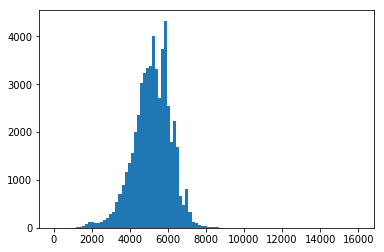

In [75]:
modeldata.count()
plt.hist(modeldata.triplength, bins=100)

In [76]:
travel_time_deviation = modeldata.triplength.std()

# 2 sigma - 95% of data
modeldata = modeldata[abs(modeldata.triplength-modeldata.triplength.mean()) < 2*travel_time_deviation]
modeldata = modeldata[modeldata.triplength >= 0]

In [77]:
# modeldata.count()
# plt.hist(modeldata.triplength, bins=100)

# Training Model

## Random Forest (skLearn)

In [78]:
# train, test = train_test_split(modeldata, test_size = 0.3, shuffle=True)

# RFM

# RFM = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
# RFM.fit(train[predictors], train[target].values.ravel())
# RFM_predictions = RFM.predict(test[predictors])

# feature_importance = pd.DataFrame({'feature':predictors, 'importance': RFM.feature_importances_})

# feature_importance.set_index('feature', inplace=True)
# feature_importance.plot.barh(title='Feature importance')

## XGBoost

In [85]:
# ========================= Test/Train Splits ========================== #
X_train, X_test, y_train, y_test = train_test_split(modeldata[predictors],modeldata[target].values.ravel(), test_size=0.3, shuffle=True)

# ========================== Making DMatrices ========================== #
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# =========================== Training Model =========================== #

param = {
#     'tree_method':'gpu_hist',
    'eta':0.1,
    'max_depth':6
}
num_rounds = 10000

model = xgb.train(param, dtrain, num_rounds, evals=[(dtest, 'Test')], verbose_eval=200, early_stopping_rounds=100)


# ============================  Predictions ============================ #
xgbpreds = model.predict(dtest)

# ====================== Feature Importance graph ====================== #
# xgb.plot_importance(model)

[0]	Test-rmse:4773.27
Will train until Test-rmse hasn't improved in 100 rounds.
Stopping. Best iteration:
[61]	Test-rmse:638.002



/home/ciaran/.conda/envs/BusEnv/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  # This is added back by InteractiveShellApp.init_path()


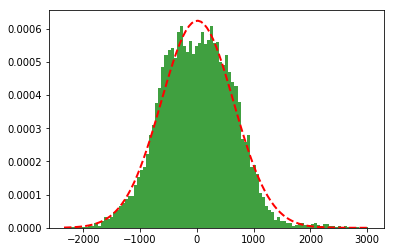

639.0907923224578 9.29254846875


<Figure size 432x288 with 0 Axes>

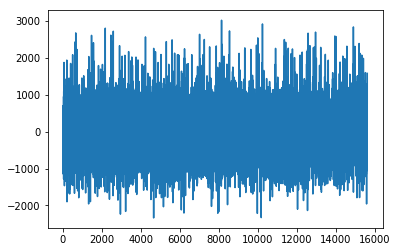

In [86]:
# ========================= Visualising Errors ========================= #
xgbresiduals = xgbpreds - y_test

# best fit of data
(xmu, xsigma) = stats.norm.fit(xgbresiduals)

# # The histogram of the data
xn, xbins, xpatches = plt.hist(xgbresiduals, 100, density=True, facecolor='green', alpha=0.75)

# add a 'best fit' line
xy = mlab.normpdf(xbins, xmu, xsigma)
xl = plt.plot(xbins, xy, 'r--', linewidth=2)
plt.show()

print(xsigma,xmu)

plt.figure()
plt.plot(xgbresiduals)

### Running models for all lineids

In [87]:
# Training Model for all lineids in dataset

lineids = combinedtrip.lineid.unique()

models = dict()

for lidn in tnrange(len(lineids)):
    
    lid = lineids[lidn]
    
    modeldata = combinedtrip[combinedtrip.lineid==lid]
#     modeldata = modeldata[modeldata.direction==1]
    
    travel_time_deviation = modeldata.triplength.std()

    # 3 sigma - 99.7% of data
    modeldata = modeldata[abs(modeldata.triplength-modeldata.triplength.mean()) < 2*travel_time_deviation]
    modeldata = modeldata[modeldata.triplength >= 0]
    
    modeldata.dropna(inplace=True)


    # ========================= Test/Train Splits ========================== #
    X_train, X_test, y_train, y_test = train_test_split(modeldata[predictors],modeldata[target].values.ravel(), test_size=0.5, shuffle=True)

    # ========================== Making DMatrices ========================== #
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # =========================== Training Model =========================== #

    param = {
    #     'tree_method':'gpu_hist',
        'eta':0.1,
        'max_depth':6
    }
    num_rounds = 10000

    try:
        models[f'Route{lid}'] = xgb.train(param, dtrain, num_rounds, evals=[(dtest, 'Test')], verbose_eval=False, early_stopping_rounds=100)
    
    except Exception as e:
        print(lid)
        modeldata.head()
        print(repr(e))

# Saving Models

In [ ]:
# import sys
# sys.getsizeof(model.best_iteration)

Random Forest (using pickle) - memory errors

In [ ]:
# save model
# pickle.dump(RFM, open("modelFiles/Route145.sav", 'w'))

# load model
# loaded_model = pickle.load(open("modelFiles/route145.sav", 'rb'))

XGBoost model

In [89]:
# model.save_model("modelFiles/route145.model")

mkeys = list(models.keys())

for k in tnrange(len(mkeys)):
    
    key = mkeys[k]
    
    models[key].save_model(f"ModelFiles/RouteModels/{key}.model")

In [90]:
# samplehow to load model.

model3 = xgb.Booster()
model3.load_model("ModelFiles/RouteModels/Route41D.model")

In [91]:
model3.predict(dtest) - models['Route41D'].predict(d)

array([2624.0928, 4115.567 , 4532.7427, 4115.567 , 3898.1335, 2968.16  ,
       4532.7427], dtype=float32)